In [1]:
import sympy as sym
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [155]:
def mdp_encoder(P, r):
    """
    Args:
        P (np.array): The transition function. shape = [n_states, n_states, n_actions]
        r (np.array): The reward function. shape = [n_states, n_actions]

    Returns:
        p (np.array): the uncontrolled transition matrix
        q (np.array): the pseudo reward

    Needs to be solved for every state.
    """
    # QUESTION Are there similarities between the action embeddings in each state?
    # QUESTION How does this embedding change the set of policies that can be represented? Does this transformation preserve the optima?
    def embed_state(idx_x):
        """
        Solves
        r(s, a) = q(s) + E_s'~p(s' | s, a) log( p(s' | s, a) / p(x' | x))
        See supplementary material of todorov 2009 for more info
        """
        # b_a = r(x, a) - E_s'~p(s' | s, a) log( p(s' | s, a) / p(x' | x))
        b = r[idx_x] + np.sum(P[:, idx_x, :] * np.log(P[:, idx_x, :]+1e-8), axis=0)
        # D_ax' = p(x' | x, a)
        D = P[:, idx_x, :]

        # D(q.1 - m) = b, c = q.1 - m
        c = np.dot(b, np.linalg.pinv(D))
        q = -np.log(np.sum(np.exp(-c)))

        m = np.sum(q) - c
        p = np.exp(m)

        return p, [q]

    # TODO, should be able to solve these in parallel.
    # maybe even share some knowledge???!
    pnqs = [embed_state(i) for i in range(P.shape[0])]
    return tuple([np.stack(val, axis=1) for val in zip(*pnqs)])

In [156]:
p000, p001, p010, p011, p100, p101, p110, p111 = sym.symbols('p000, p001, p010, p011, p100, p101, p110, p111')
P = sym.Array([[[p000, p001], [p010, p011]], [[p100, p101], [p110, p111]]])

In [157]:
r00, r01, r10, r11 = sym.symbols('r00, r01, r10, r11')
r = sym.Matrix([[r00, r01], [r10, r11]])

In [165]:
def random_sparse_mdp(n_states, n_actions):
    r = np.random.random((n_states, n_actions))
    r[0,0] = 30
    
    P = np.stack([np.random.permutation(np.eye(n_states)) for i in range(n_actions)], axis=2)
    return P, r

In [166]:
n_states = 4
n_actions = 2
P, r = random_sparse_mdp(n_states, n_actions)

In [167]:
P[:, :, 0], P[:, :, 1]

(array([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]), array([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]]))

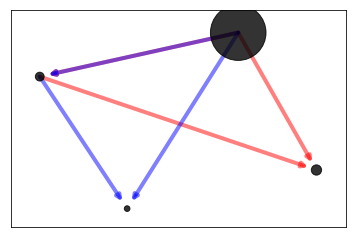

In [168]:
graphs = [nx.from_numpy_matrix(P[:, :, i]) for i in range(n_actions)]
edges = [g.edges() for g in graphs]
colors = ['r', 'b', 'g', 'y']

# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
G = nx.DiGraph()
G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
G.graph['graph'] = {'scale': '3'}

for i in range(n_states):
    G.add_node(i)
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos,
                       nodelist=range(n_states),
                       node_color='k',
                       node_size=np.sum(r, axis=1)*100,
                       alpha=0.8)

for i, e, c in zip(range(n_states), edges, colors):
#     if i == 1:
    nx.draw_networkx_edges(G, pos, edgelist=e,
                       width=4, alpha=0.5, edge_color=c)

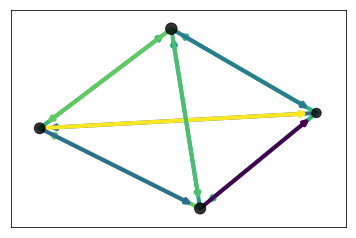

In [169]:
# plt.subplot(1, 2, 2)
p, q = mdp_encoder(P, r)
G = nx.DiGraph()
for i in range(n_states):
    G.add_node(i)
pos = nx.spring_layout(G)



nx.draw_networkx_nodes(G, pos,
                       nodelist=range(n_states),
                       node_color='k',
                       node_size=np.abs(q)*100,
                       alpha=0.8)

new_g = nx.from_numpy_matrix(p, create_using=nx.DiGraph())
edges,weights = zip(*nx.get_edge_attributes(new_g,'weight').items())
_ = nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=weights,
                   width=4, alpha=0.5)

In [170]:
p

array([[4.13094149e-01, 2.68264241e-01, 1.52199755e-01, 2.69924418e-01],
       [3.86557926e-14, 2.92453959e-01, 3.12528176e-01, 2.35895861e-01],
       [4.13094149e-01, 1.46827842e-01, 2.22743893e-01, 2.69924418e-01],
       [1.73811701e-01, 2.92453959e-01, 3.12528176e-01, 2.24255303e-01]])

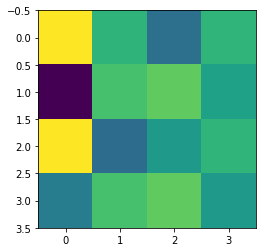

In [171]:
plt.imshow(p)

In [65]:
def local_permutation(A, i):
    n = A.shape[0]
    idx = list(range(n))
    idx[i], idx[i+1] = idx[i+1], idx[i]
    return A[idx]

In [70]:
local_permutation(np.eye(12), 3)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])